In [1]:
import pandas as pd

from nltk.stem.snowball import SpanishStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from stop_words import get_stop_words

import matplotlib.pyplot as plt
import matplotlib.colors
from pyvis import network as net
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

from loguru import logger


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np

MAX_FEATURES=225
def Get_Vectorizado_TfidfVectorizer(df,stop, max_features=MAX_FEATURES):

    tf = TfidfVectorizer(analyzer='word',
                        ngram_range=(2,3),
                        max_features=max_features,
                        min_df = 0, 
                        stop_words = stop, 
                        sublinear_tf=True)

    X =  tf.fit_transform(df['stem'].values)

    tf_transformer = TfidfTransformer(use_idf=False).fit(X)
    feature_names = tf.get_feature_names()

    df_vectorizado = pd.DataFrame(X.A, columns=feature_names ) 
    #df_vectorizado = df_vectorizado.astype(bool).astype(int)

    # Añadimos el campo problem, que sera el campo a predecir
    df_vectorizado["title"] = df["title"] 
    df_vectorizado.set_index('title', inplace=True)
    return df_vectorizado



def Get_Distance_Matrix(df_vectorizado):
    """ Given a dataframe with the vectorized values, return a reverse distance df, where 1 indicates minimun distance and 0 maximun distance between titles"""
    df_distance =pd.DataFrame(distance_matrix(df_vectorizado.values, df_vectorizado.values), index=df_vectorizado.index, columns=df_vectorizado.index)
    #df_distance.loc[busqueda].sort_values(ascending=True)
    mms = MinMaxScaler()
    df_distance2 = mms.fit_transform(df_distance)
    df_temp = pd.DataFrame(df_distance2, columns = df_distance.columns, index=df_distance.index)
    df_temp =  -1 * (df_temp  - 1 )
    df_distance = df_temp
    return df_distance


In [3]:
def do_stemmer(df, stop_language='spanish'):
    """Apply stop words and Stemmers"""
    ##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
    stop  = get_stop_words(stop_language) + get_stop_words('english')
    ## Añdimos nuestras propias palabras
    stop += ["buenas", "buenos" ,"cid", "dias", "gracias", "hola","mucho","mucha" ,"poder","proyecto","please" ,"saludo","tardes","www","habia"]
    stop += ['ahora',
        'algun',
        'alguna',
        'amanecia interrumpio',
        'amanecia interrumpio relato',
        'amanecia interrumpio relato habian',
        'amanecia interrumpio relato habian dado',
        'aquel',
        'asi',
        'aun',
        'cada',
        'vez',
        'mas',
        'cualquier',
        'cosa',
        'cuanto',
        'dado',
        'darse',
        'debe',
        'debia',
        'despues',
        'dia noche',
        'dia siguiente',
        'diez años',
        'diez mil',
        'dijo',
        'dijo',
        'dio',
        'habia',
        'mas',
        'podia',
        'podian',
        'mismo',
        'si',
        'tal',
        'tan',
        'puede',
        'pueden ser',
        'pues',
        'puso',
        'toda',
        'todas',
        'vease tambien',
        'primer lugar',
        'varias',
        'dos',
        'largo',
        'hacia'
        'uno','una','unos','una','aquella','aquello','aquel',
        'hace',
        'muchas',
        'mucho',
        'muchos',
        'mucha',
        'pueden',
        'puedo',
        'unas',
        'abrio puerta',
        'arriba abajo',
        'aqui alla',
        'habian',
        'doña','don','señor','señora','hizo','quedo',
        'fuerza sino', 
        'quedo perplejo',
        'parece haber',
        'parece ser',
        'parecia haber',
        'mayor parte',
        'mañana siguiente',
        'media hora',
        'hoy dia',
        'iba ser',
        'iii pag',
        'haber hecho',
        'habria podido',
        'hacer cosas',
        'hacia arriba',
        'hacia atras',
        'hacia puerta',
        'hacia tiempo',
        'decir verdad',
        'dejo caer',
        'demasiado tarde',
        'derecha izquierda',
        'di cuenta',
        'dia anterior',
        'dia noche',
        'dia siguiente',
        'casi siempre',
        'cierto dia',
        'cierto modo',
        'cinco años',
        'aqui alla',
        'arriba abajo',
        'aunque solo',
        'año nuevo',
        'años edad',
        'buena parte',
        'ninguna parte',
        'noche anterior',
        'noche dia',
        'nunca visto',
        'partido comunista',
        'podria haber',
        'podria ser',
        'press cambridge',
        'primer lugar',
        'quiere decir',
        'quiero decir',
        'sentido comun',
        'seria mejor',
        'tras haber',
        'tres años',
        'tres cuatro',
        'tres meses',
        'voz alta',
        'voz baja',
        ]

    ps = SpanishStemmer()

    a=[]
    df["stem"]="n"
    for i, row in df.iterrows():
        a.append( ps.stem(row["text"]).replace('fuerza sino', '').replace('acceder', 'acceso').replace('user', 'usuario').replace('access', 'acceso').replace('usuarios', 'usuario').replace('abrio puerta','').replace('acto seguido','')
        
        )
    df["stem"]= a 
    return df,stop



In [4]:
def Get_Better_Correlations(busqueda,df_distance,number_elements=10 ):
    """ Return a df with the correlation between a title and the others"""
    df = df_distance.loc[busqueda].to_frame()
    df.reset_index(inplace=True)
    df.insert(0, 'title1', busqueda)
    df.rename(columns={'title': 'title2', }, inplace=True)
    df.columns = [*df.columns[:-1], 'correlation']
    df = df.sort_values("correlation", ascending=False )
    df = df.iloc[1:]
    return df.head(number_elements)

    
#df_related = Get_Better_Correlations("Mitos y falacias de la historia de España",df_distance,number_elements=10)   
#df_related

In [5]:

#def Get_Correlation(title1,title2,df_vectorizado):
#    """ Return number of common dimensions for two title
#    Returns
#    -------
#    number of common terms
#    list of common terms
#    """
#    #logger.debug(title1,title2)
#    a = df_vectorizado.loc[title1].values
#    b = df_vectorizado.loc[title2].values
#    df_vectorizado.loc[title2].to_dict()
#    a = df_vectorizado.loc[title1]
#    b = df_vectorizado.loc[title2]
#    c = a + b 
#    df_result = pd.DataFrame(c)
#    df_result.columns=["correlation"]
#    mylist= df_result.query("correlation == 2 ").index.values
#    return len(mylist), mylist

#def Get_Better_Correlations(title1,df_vectorizado,number_elements=5):
#    """ Return a df with the correlation between a title and the others"""
#    #logger.debug(title1)

#    array_results = []
#    for title in df_vectorizado.index.values:
#        if title == title1 : continue
#        #logger.debug(title)
#        correlation, common_terms = Get_Correlation(title,title1,df_vectorizado) 
#        array_results.append( { "title1" : title1 ,  
#            "title2": title ,  
#            "correlation" : correlation,
#            "common_terms"  : common_terms})
#    df = pd.DataFrame(array_results)
#    return df.sort_values("correlation", ascending=False ).head(number_elements)
 
#df_related = Get_Better_Correlations("Mitos y falacias de la historia de España",df_vectorizado,number_elements=10)   
#df_related
###



In [6]:
import networkx as nx
import matplotlib.pyplot as plt


def get_chart(busqueda,df_distance ,number_elements_primary=5,number_elements_secondary=5):
    df_results=pd.DataFrame()
    df_array=[]
    df_related = Get_Better_Correlations(busqueda,
            df_distance ,
            number_elements=number_elements_primary)   
    df_array.append(df_related)

    for title_secondary in df_related['title2'].values: 
        df_related_secondary = Get_Better_Correlations(
            title_secondary,
            df_distance  , 
            number_elements = number_elements_secondary)     
        df_array.append(df_related_secondary)

    df_results =pd.concat(df_array)
    G = nx.Graph( )

    for row in df_results.to_dict('records') :
        G.add_node(row['title2'], **{"title": row['title2'] })
        edge_attributes = { "common_terms" : row['title2'] , 'weight' : row['correlation'] } 
        G.add_edge( row['title1'], row['title2'], **edge_attributes)

    labels = nx.get_node_attributes(G, 'title') 

    nx.draw(G,labels=labels)
    df_results= df_results.sort_values("correlation", ascending=False )

    return df_results,G


def Display_Interactive_Chart(G):
  network=net.Network(notebook=True)
  network.set_options("""var_options = {
    "edges": {
      "color": {
        "inherit": true
      },
      "smooth": false
    },
    "interaction": {
      "navigationButtons": true
    },
    "physics": {
      "minVelocity": 0.75,
      "solver": "repulsion"
    }
  }""")

  network.prep_notebook()
  network.height = '760px'
  network.width = '100%'
  network.from_nx(G)
  #network.show("example.html")
  return network





2020-11-29 16:14:46.895 | INFO     | __main__:<module>:3 - Load Data
2020-11-29 16:14:47.383 | INFO     | __main__:<module>:6 - Clean Data
2020-11-29 16:14:50.666 | INFO     | __main__:<module>:10 - Vectorize Data
2020-11-29 16:15:51.545 | INFO     | __main__:<module>:16 - Generate distance data
2020-11-29 16:15:51.571 | INFO     | __main__:<module>:22 - search=Los Estados Unidos Desde 1816 Hasta La Guerra Civil
2020-11-29 16:15:51.658 | INFO     | __main__:<module>:30 - Display results for Los Estados Unidos Desde 1816 Hasta La Guerra Civil


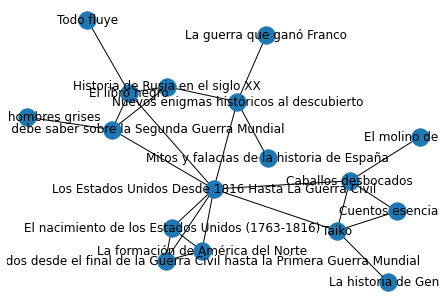

In [7]:
MAX_FEATURES=225

logger.info("Load Data")
df = pd.read_csv("/home/jaimevalero/git/books_recommendation/books.csv")

logger.info("Clean Data")
df,stop = do_stemmer(df,stop_language='spanish')
df.to_csv("stemmized.csv")

logger.info("Vectorize Data")
df_vectorizado = Get_Vectorizado_TfidfVectorizer(df,stop,max_features=MAX_FEATURES)
df_vectorizado.to_csv("vectorized.csv")

df = pd.read_csv("vectorized.csv")

logger.info("Generate distance data")
df_distance = Get_Distance_Matrix(df_vectorizado)
df_distance.to_csv("distances.csv")


busqueda='Los Estados Unidos Desde 1816 Hasta La Guerra Civil'
logger.info(f"search={busqueda}")


df_results,G = get_chart(busqueda,
            df_distance ,
            number_elements_primary=8,
            number_elements_secondary=3)

logger.info(f"Display results for {busqueda}")
network = Display_Interactive_Chart(G)

df_results


network.show("example.html")
